## 4.3　交互作用と多項式

線形モデルの特徴量表現を豊かにするものとして、**交互作用特徴量**と**多項式特徴量**がある。

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

print(X.shape)
print(y.shape)

(100, 1)
(100,)


In [3]:
bins = np.linspace(-3, 3, 11)
which_bin = np.digitize(X, bins=bins)

print('bins: {}'.format(bins))
print('\nData points:\n', X[:5])
print('\nBin membership for data points:\n', which_bin[:5])

bins: [-3.  -2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4  3. ]

Data points:
 [[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]

Bin membership for data points:
 [[ 4]
 [10]
 [ 8]
 [ 6]
 [ 2]]


In [4]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(which_bin)

X_binned = encoder.transform(which_bin)

line_binned = encoder.transform(np.digitize(line, bins=bins))

print('X_binned.shape: {}'.format(X_binned.shape))
pd.DataFrame(X_binned[:5].astype(int), index=np.arange(1, 6), columns=np.arange(1, 11))

X_binned.shape: (100, 10)


,1,2,3,4,5,6,7,8,9,10
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0


np.digitizeは、あるデータの値がどのビンに含まれているのかを返す関数である。

In [5]:
a = np.random.uniform(0, 100, 5)
print(a)

b = np.digitize(a, bins=[15, 30, 45, 50, 60])
print(b)

[69.97802601 87.67929773 74.09401995 61.13995765 46.04522513]
[5 5 5 5 3]


線形モデルに傾きを学習させるための処理をしていく。

In [6]:
pd.DataFrame(X[:5])

,0
0,-0.752759
1,2.704286
2,1.391964
3,0.591951
4,-2.063888


XとX_binedを横結合する。

In [7]:
X_combined = np.hstack([X, X_binned])

print(X_combined.shape)
pd.DataFrame(X_combined[:5])

(100, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,-0.752759,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.704286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.391964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.591951,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-2.063888,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


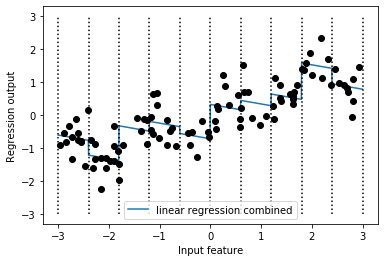

In [8]:
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

for bin in bins:
    plt.plot([bin, bin],[-3, 3], ':', c='k')
    
plt.legend(loc='best')
plt.ylabel('Regression output')
plt.xlabel('Input feature')
plt.plot(X[:, 0], y, 'o', c='k')

上記は**ビニングされた特徴量（X_binned）**と単一の傾きに対する線形回帰である。

このグラフでは、全てのビンにおいて同じ傾きとなってしまっている。<br>
これを、ビンごとの傾きとして表示させたい。

そのためには、**データポイントがどのビンに入っているかの特徴量（X_binned）**と<br>
**$x$軸のどこにあるかを示す特徴量（X）**、この2つの交互作用もしくは**積（X * X_binned）**を特徴量に加えれば良い。

In [9]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(100, 20)


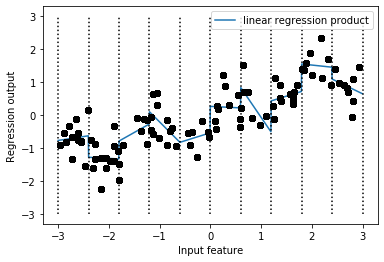

In [10]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
    
    plt.plot(X[:, 0], y, 'o', c='k')
    plt.ylabel('Regression output')
    plt.xlabel('Input feature')
    plt.legend(loc='best')

ビンごとの傾きにて表示されていることが分かる。

このように、ビニングは連続値特徴量を拡張する1つの方法である。<br>
もう1つの方法としては、多項式を扱う方法がある。

ある特徴量xに対して、$x^2, x^3, x^4$などを考えるものである。<br>
次の例では、$x^{10}$までの多項式を加えている。（degreeで何次まで加えるかを指定できる）

In [11]:
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

include_bias=Trueだと、常に1となる特徴量を加える。

In [12]:
print('X_poly.shape: {}'.format(X_poly.shape))

X_poly.shape: (100, 10)


In [13]:
pd.DataFrame(X, columns=['x']).head()

,x
0,-0.752759
1,2.704286
2,1.391964
3,0.591951
4,-2.063888


In [14]:
pd.DataFrame(X_poly, columns=['x', 'x^2', 'x^3', 'x^4', 'x^5', 'x^6', 'x^7', 'x^8', 'x^9', 'x^10']).head()

,x,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10
0,-0.752759,0.566647,-0.426548,0.321088,-0.241702,0.181944,-0.136960,0.103098,-0.077608,0.058420
1,2.704286,7.313162,19.776880,53.482337,144.631526,391.124988,1057.713767,2860.360362,7735.232021,20918.278410
2,1.391964,1.937563,2.697017,3.754150,5.225640,7.273901,10.125005,14.093639,19.617834,27.307312
3,0.591951,0.350406,0.207423,0.122784,0.072682,0.043024,0.025468,0.015076,0.008924,0.005283
4,-2.063888,4.259634,-8.791409,18.144485,-37.448187,77.288869,-159.515582,329.222321,-679.478050,1402.366700


個々の特徴量の意味を取得することもできる。

In [15]:
print('Polynomial feature names:\n{}'.format(poly.get_feature_names()))

Polynomial feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


In [16]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,x0^10
0,-0.752759,0.566647,-0.426548,0.321088,-0.241702,0.181944,-0.136960,0.103098,-0.077608,0.058420
1,2.704286,7.313162,19.776880,53.482337,144.631526,391.124988,1057.713767,2860.360362,7735.232021,20918.278410
2,1.391964,1.937563,2.697017,3.754150,5.225640,7.273901,10.125005,14.093639,19.617834,27.307312
3,0.591951,0.350406,0.207423,0.122784,0.072682,0.043024,0.025468,0.015076,0.008924,0.005283
4,-2.063888,4.259634,-8.791409,18.144485,-37.448187,77.288869,-159.515582,329.222321,-679.478050,1402.366700


このような多項式特徴量を使用して線形回帰を行うことで、多項式線形回帰モデルを作成することができる。

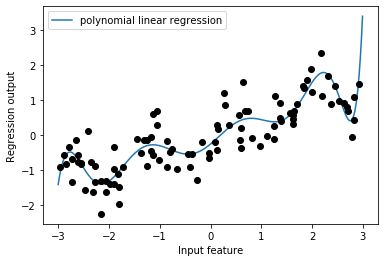

In [17]:
reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel('Regression output')
plt.xlabel('Input feature')
plt.legend(loc='best')

上記のように、予測値とlineを使って、作成した線形回帰モデルをプロットすることができる。

多項式特徴量は、この1次元の特徴量に対してスムーズに適合しているが<br>
高次の多項式では、境界近辺やデータが少ない領域において極端な振る舞いを示すことが多い。<br>
カーネル法を用いたSVMモデルと比較をしてみる。

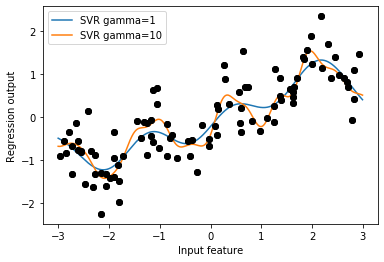

In [18]:
for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))
    plt.plot(X[:, 0], y, 'o', c='k')
    plt.ylabel('Regression output')
    plt.xlabel('Input feature')
    plt.legend(loc='best')

このような複雑なモデル（カーネルSVMなど）では、特徴量変換を行わなくても、多項式回帰と同じように複雑な予測をできる。<br>

次に、boston_housingデータセットでも試してみる。

In [19]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

print(X_train.shape)
print(X_test.shape)

(379, 13)
(127, 13)


In [20]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

2次までの多項式特徴量と交互作用を確認する。

In [21]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print('X_train.shape: {}'.format(X_train.shape))
print('X_train_poly.shape: {}'.format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


元のデータの13個の特徴量を、105個までに拡張した。詳細は次のようになる。

In [22]:
print('Polynomial feature names:\n{}'.format(poly.get_feature_names()))

Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


最初は1で始まり、次にそれぞれの特徴量、その次に特徴量の組み合わせと特徴量の二乗が続いている。<br>
Ridge回帰を用いて、交互作用特徴量の有無について比較してみる。

In [23]:
ridge = Ridge().fit(X_train_scaled, y_train)
print('Score without interactions: {:.3f}'.format(ridge.score(X_test_scaled, y_test)))

ridge = Ridge().fit(X_train_poly, y_train)
print('Score with interactions: {:.3f}'.format(ridge.score(X_test_poly, y_test)))

Score without interactions: 0.577
Score with interactions: 0.741


Ridge回帰の場合では、交互作用特徴量の方が圧倒的にスコアが高い。<br>
しかし、これがランダムフォレストのような複雑なモデルでは、少し話が変わってくる。

In [25]:
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print('Score without interactions: {:.3f}'.format(rf.score(X_test_scaled, y_test)))

rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print('Score with interactions: {:.3f}'.format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.776
Score with interactions: 0.752


追加の特徴量がなくても、ランダムフォレストはRidgeの性能を上回る。<br>
そしてランダムフォレストの場合、交互作用特徴量と多項式特徴量を入れると性能が下がっていることが分かる。